# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 ноября, -4 балла после 06:00 24 ноября, -6 баллов после 06:00 1 декабря, -8 баллов после 06:00 8 декабря.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Тимохин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. Логистическая регрессия в ней в параграфе 4.3

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
где $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал тогда принимает вид:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту регуляризацию в функцию потерь.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации. Отметим, что вне зависимости от алгоритма оптимизации, данная модель все равно будет называться ***логистической регрессией***.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь c L1-регуляризацией  могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для логистической регрессии.
* Посчитайте градиент функции потерь по весам для модели логистической регрессии с конкретно Вашей регуляризацией:

$$ \nabla_w L = \dots $$

 Отнеситесь к этому пункту максимально серьезно, этот градиент Вам нужно будет реализовать в задании.

***Ваше решение здесь***

$$L(w) = - \frac{1}{N}\left[\sum \limits_{i=1}^{N} y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}\sum \limits_{j=1}^{D} w_j^2$$


$$ \nabla_w L = \sum \limits_{j=1}^{D}\bigg[\frac{1}{N}\sum \limits_{i=1}^{N} (a_i - y_i)x_{ij}+2w_j \bigg]dw_j $$


$$grad_L=(\frac{\partial L}{\partial w_1}, \dots, \frac{\partial L}{\partial w_D})$$

Задача 2. Анализ поведения градиента.

Посчитав формулу градиента, подумайте, как будут меняться веса в зависимости  от "вида" ошибки: 
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

Вам такое поведение кажется логичным?

***Ваше решение здесь***

$$1)\ Если\ y = 1,\ а\ \sigma \to 0,\ то\ -(\sigma - y) > 0 \implies веса\ увеличиваются\ при\ x > 0,\ и\ уменьшаются\ при\ x < 0$$


$$2)\ Если\ y = 0,\ а\ \sigma \to 1,\ то\ -(\sigma - y) < 0 \implies веса\ увеличиваются\ при\ x < 0,\ и\ уменьшаются\ при\ x > 0$$

Задача 3. Сравнение с линейной регрессией.

Как было рассказано на лекции, функция потерь линейной регрессии без регуляризации имеет вид:
$$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] $$
где $a(x_i)$ предсказания модели на $i$ объекте, $y_i$ $-$ значение целовой переменной на $i$ объекте, $N$ $-$ размер выборки.
$a(x_i)$ через веса и признаки вычисляется как:
$$ a(x_i) =  \langle\,x_i,w\rangle $$
где $x_i$ $-$ вектор признаков, $w$ $-$ вектор весов модели.
* Посчитайте градиент  функции потерь по весам для модели линейной регрессии:
$$ \nabla_w L = \dots $$
Как соотносится этот градиент с градиентом, возникающий в задаче логистической регресии? Вас это удивило, Вы это уже раньше заметили или Вам все равно? 

***Ваше решение здесь***

$$ \frac{\partial L( w )}{\partial w_j} = \frac{2}{N}\left[\sum_i x_{ik}(a(x_i) - y_i) \right] $$
Логично)

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

Найдем точку минимум мат. ожидание


$$\frac{dE(L,x_i)}{da(x_i)} = -\frac{p(y_i=1|x_i)}{a(x_i)} + \frac{p(y_i=0|x_i)}{1 - a(x_i)} = 0$$


$$\big(p(y_i=1|x_i) + p(y_i=0|x_i)\big)a(x_i)-p(y_i=1|x_i) = a(x_i)-p(y_i=1|x_i)=0$$


$$a(x_i)=p(y_i=1|x_i)$$

#  Реализация логистической регрессии (6 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [3]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [4]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [5]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [6]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [7]:
#%%pycodestyle
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    coords = np.arange(X.shape[0], dtype=int)
    if shuffle:
        np.random.shuffle(coords)
    X = X[coords]
    y = y[coords]
    for i in range(0, X.shape[0], batch_size):
        m = min(X.shape[0], i+batch_size)
        X_batch = X[i:m]
        y_batch = y[i:m]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [8]:
#%%pycodestyle


def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    """

    return 1 / (1 + np.exp(-X))


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """

        sigmoids = sigmoid(X_batch @ self.weights)
        loss = -np.sum(y_batch * np.log(sigmoids) + (1 - y_batch) * \
                       np.log(1-sigmoids)) / X_batch.shape[0]
        return loss + np.sum(self.weights ** 2) / self.C

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """

        sigmoids = sigmoid(np.dot(X_batch, self.weights))
        loss_grad = np.dot(sigmoids - y_batch, X_batch) / X_batch.shape[0]
        return loss_grad + 2 * self.weights / self.C

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """

        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        X = np.column_stack((X, np.ones((X.shape[0]))))
        # Нужно инициализровать случайно веса
        self.weights = np.random.uniform(-1, 1, size=X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=4)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                """
                Смотря какую цель преследовать
                Если мы хотим убедиться в том, что модель обучается, то после итерации
                    градиентного спуска

                Если же мы хотим оценивать адаптивность модели - то до
                """
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''

        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        values = self.predict_proba(X)
        return (values >= 0.5).astype('int')

    def predict_proba(self, X):
        '''
        Предсказание вероятности положительного класса
        X - матрица объекты-признаки
        '''

        X = np.column_stack((X, np.ones((X.shape[0]))))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        return sigmoid(X @ self.waights)


Запустите ваш алгоритм на синтетических данных. 

Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [9]:
def plot_decision_boundary(clf):
    x = np.linspace(-2, 6, 2)
    y = -(clf.weights[2] + clf.weights[0] * x) / clf.weights[1]
    plt.plot(x, y)

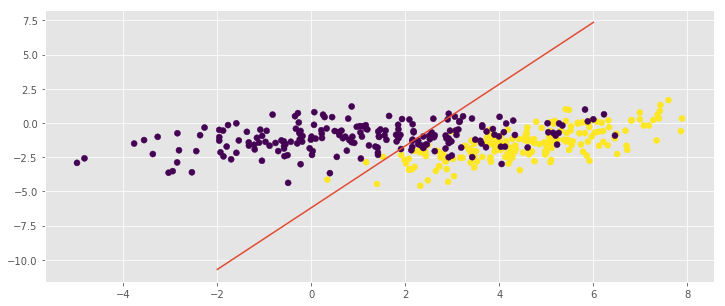

In [10]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(batch_generator, C=100)
clf.fit(X, y)

plot_decision_boundary(clf)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [11]:
from sklearn.datasets import make_classification

In [12]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

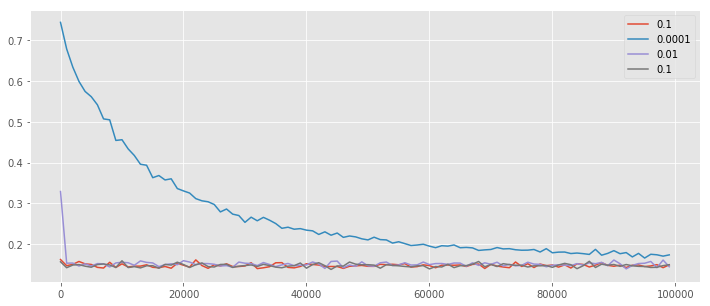

In [13]:
alpha = [1e-1, 1e-4, 1e-2, 1e-1]
n = 1000
for a in alpha:
    clf = MySGDClassifier(batch_generator, C=100, alpha=a, max_epoch=5)
    clf.fit(X,y)
    var = np.arange(0, len(clf.errors_log['loss']), n)
    loss_data = [np.mean(clf.errors_log['loss'][i:i + n]) for i in var]
    plt.plot(var, loss_data)
plt.legend(alpha)    
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем выше скорость спуска - тем больше вероятность проскочить минимум

Но при малых alpha градиентный спуск становятся медленным

Из графика видно, что оптимальным из приведенных значений параметра является 0.01

Изобразите график среднего значения весов модели в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/deadsonger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
/home/deadsonger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
/home/deadsonger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/home/deadsonger/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/deadsonger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/deadsonger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in true_divide


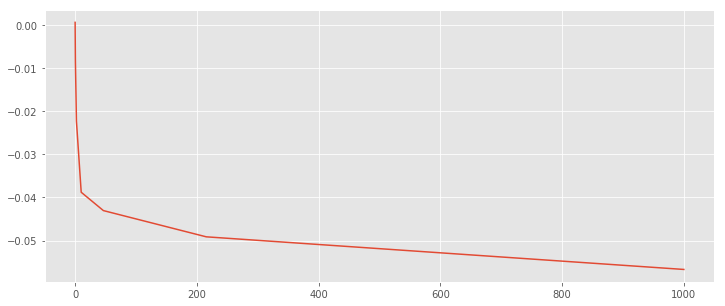

In [14]:
с_values = np.logspace(3, -3, 10)
weights_data = []
for c in с_values:
    clf = MySGDClassifier(batch_generator, C=c)
    clf.fit(X,y)
    weights_data.append(np.mean(clf.weights))
plt.plot(с_values, weights_data)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? Если нет, то как можно было бы уменьшать их еще сильнее?

Регуляризация препятствует избыточному росту модуля весов

Чем меньше параметр - тем сильнее ограничение

из Графика видно, что регуляризация справляется со своей работой

# Боевое применение (2  балла)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [15]:
# Загрузка данных для обучения
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [16]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [17]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [18]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [19]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504702

## Обучение модели

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы. (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Стандартизируйте признаки с помощью `StandartScaller` из sklearn (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Обучите модель, подбирая параметры на отложенном контроле

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [21]:
df =  pd.get_dummies(df_data, columns=
                    ['player_special_skill_used',
                     'opponent_special_skill_used',
                     'player_hero_card_id', 
                     'opponent_hero_card_id'])
X = df.drop('decision', axis=1)
y = df['decision'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X[:10000]
y = y[:10000]

In [22]:
params = {'alpha': [0.01, 0.1], 'C': [0.5, 100]}
gsv = GridSearchCV(MySGDClassifier(batch_generator, max_epoch=1), params, n_jobs=5)
gsv.fit(X, y)
clf = gsv.best_estimator_


## Применение модели 
* Подготовьте тестовые данные  к подаче на вход в алгоритму (нужно сделать такие же преобразования, как при обучении)
* Примените модель оцените качество на тесте с помощью меры ROC-AUC (имплментацию взять из sklern.metrics)


In [23]:
# Загрузка данных для тестирования
filepath_test = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_data_test = pd.read_csv(filepath_test, sep=',')

In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')
df_data_test = pd.get_dummies(df_data_test, columns=
                    ['player_special_skill_used',
                     'opponent_special_skill_used',
                     'player_hero_card_id', 
                     'opponent_hero_card_id'])
X_test = df_data_test.drop('decision', axis=1)
y_test = df_data_test['decision']
X_test = scaler.transform(X_test)
roc_auc_score(y_test, clf.predict(X_test))

0.6752703192511258

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***

Логистическая регрессия решает задачу классификации (предсказание метки из конечного множества), линейная - регрессии (предсказание значения из бесконечного множкства)

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***

Линейные модели слишком долго обучаются, чтобы их было комфортно использовать на больших данных

Но линейную модель 1) легко интерпритировать 2) можно взять за первое приближение для использовании более сложных методов

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***

Сложность градиентного спуска O(N*D)

Сложность стохастического градиентного спуска O(D) (при использовании 1-го объкта на каждом шаге)

Сложность Предсказания на однос объекте O(D)

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

Стохастический градиентный спуск позволяет не загружать все данные целиком в память, что полезно при работе с большими объемыми данных, также сложность одной итерации алгоритма уменьшается, но сложность эпохи сохраняется

Минусом этого метода является более медленная, по сравнению с классичесским алгоритмом, скорость сходимости

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

При отлаживании удобно смотреть на смотреть на ошибку полученную после итерации градиентного спуска, чтобы убедиться в сходимости алгоритма

Однаго более информативным является значение ошибки посчитанной перед итерацией, так как по этой величине можно примерно оценить адаптивные свойства получившейся модели

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

Для обработки несложных по организации данных задач удобнее будет использовать линейные модели, так как обучнную линейную модель намного проще интерпритировать чем обученную нейросеть

Так же можно использовать результаты полученные при обучении линейной модели для построение более сложных

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***